(1080, 1920, 3)

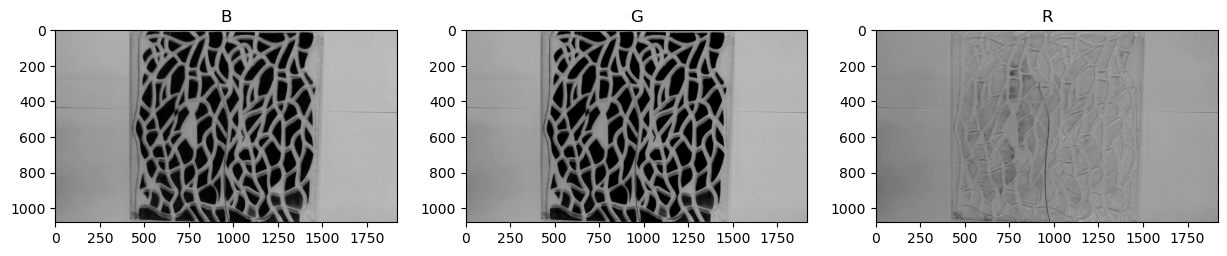

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

image = cv2.imread("Data/Datasets/RigidModelVideo-2-20/2-20-1-clip1/frame0131.jpg")
ref_stack = 

# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# plt.imshow(image, cmap='gray')
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.imshow(image[:, :, 0], cmap='gray')
ax1.set_title('B')
ax2.imshow(image[:, :, 1], cmap='gray')
ax2.set_title('G')
ax3.imshow(image[:, :, 2], cmap='gray')
ax3.set_title('R')
image.shape

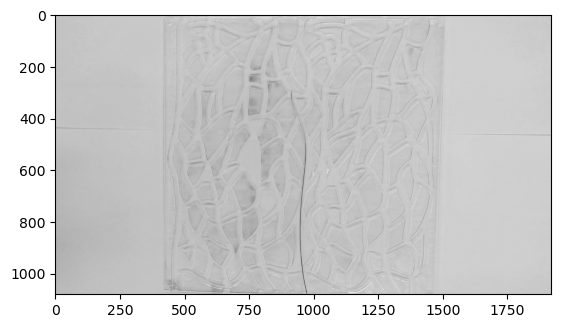

In [94]:
image_r = image[:, :, 2]
gamma = 0.4
image_r_e = np.power(image_r/255.0, gamma) * 255.0
plt.imshow(image_r_e, cmap='gray')

<BarContainer object of 256 artists>

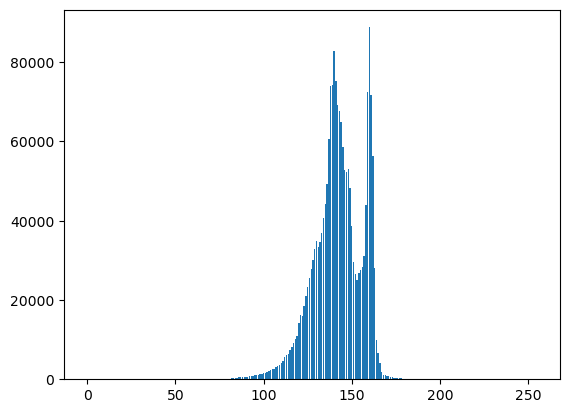

In [95]:
hst, _ = np.histogram(image_r, bins=256, range=(0, 256))
plt.bar(np.arange(256), hst)

In [96]:
# Assue it takes no more than 5% of the image
np.percentile(image_r, 5)

119.0

104
66
38
22
13
7


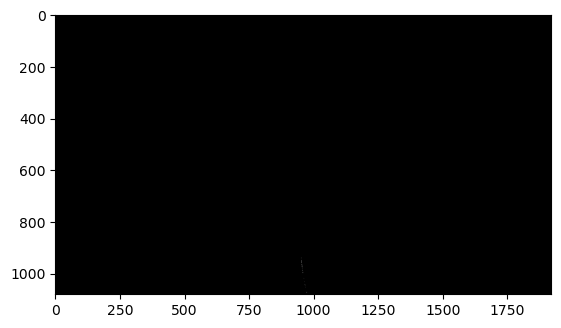

In [97]:
from skimage.filters import threshold_otsu



def recursive_otsu(image, count=5):
    threshold = threshold_otsu(image)
    print(threshold)
    binary = image[image < threshold]
    if count > 0:
        return recursive_otsu(binary, count-1)
    else:
        return threshold
    
th = recursive_otsu(image_r[image_r < np.percentile(image_r, 10)], 5)
plt.imshow(image_r < th, cmap='gray')

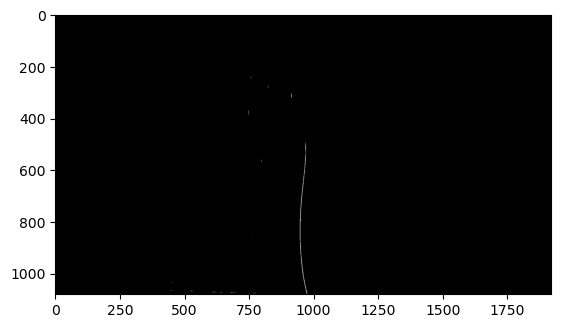

In [98]:
plt.imshow(image_r < 56, cmap='gray')

2 rounds of otsu will suffice

In [99]:
# Class dif by 5% pct:
def suggest_c_pct(image, pct=5):
    t = np.percentile(image, pct)
    return np.mean(image[image > t]) - np.mean(image[image < t])

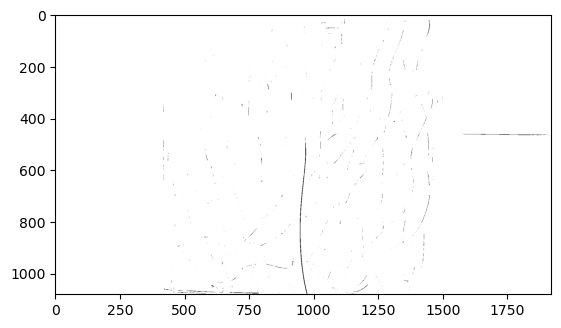

In [100]:
bin = cv2.adaptiveThreshold(image_r, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blockSize=23, C=suggest_c_pct(image_r, 3))
plt.imshow(bin, cmap='gray')

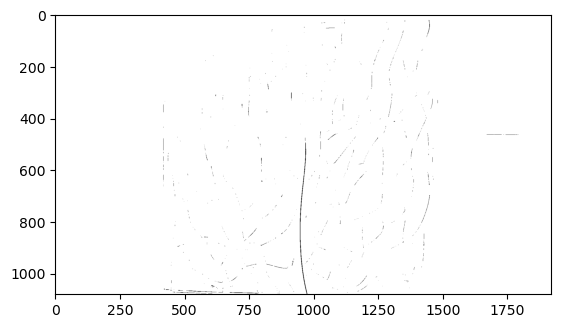

In [101]:
# Drop contrast of highlight
def adaptive_threshold(image, maxValue, block_size, C, max_block_mean=120):
    new_image = np.copy(image)
    new_image[new_image > max_block_mean] = max_block_mean
    return cv2.adaptiveThreshold(new_image, maxValue, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize=block_size, C=C)

bin = adaptive_threshold(image_r, 255, 33, C=suggest_c_pct(image_r, 5), max_block_mean=np.percentile(image_r, 60))
plt.imshow(bin, cmap='gray')

In [102]:
mask = np.invert(bin.astype(bool))
mask.sum()

5654

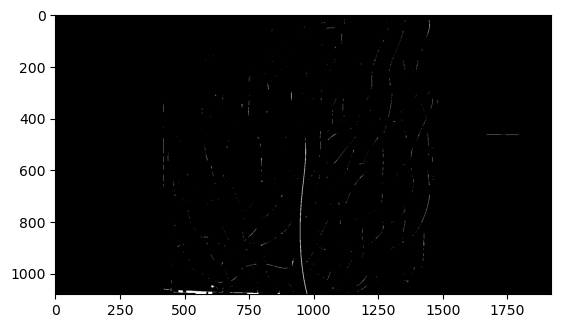

In [103]:
tmp = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
plt.imshow(tmp, cmap='gray')

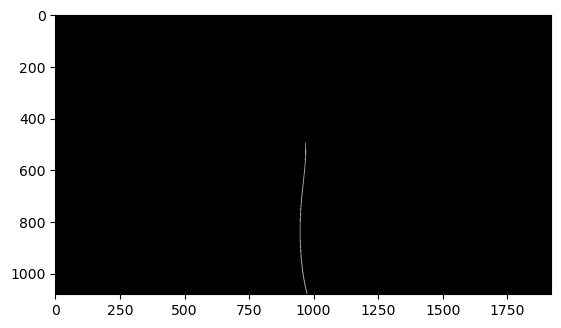

In [104]:
num, labeled, stats, centroids = cv2.connectedComponentsWithStats(tmp, connectivity=8)

sizes = stats[1:, -1]
# plt.hist(sizes, bins=100)

#Take only the biggest one
mask = labeled == (np.argmax(sizes) + 1)
plt.imshow(mask, cmap='gray')

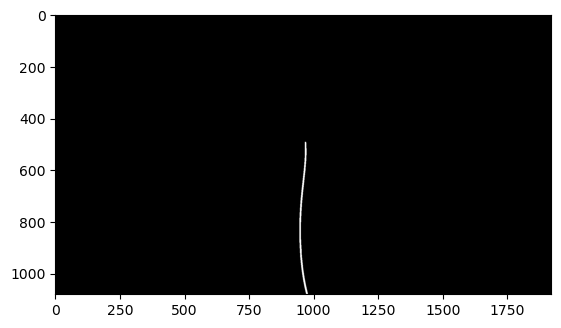

In [105]:
from skimage.morphology import skeletonize

mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_DILATE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
plt.imshow(mask, cmap='gray')


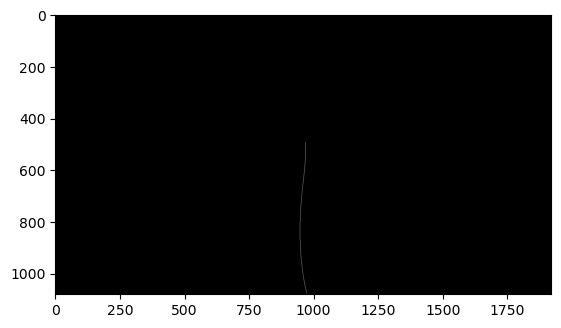

In [106]:
skeleton = skeletonize(mask)
plt.imshow(skeleton, cmap='gray')

In [107]:
def find_endpoint(skeleton):
    connectivity = find_connectivity(skeleton)
    # print(np.unique(connectivity, return_counts=True))
    return np.argwhere(connectivity == 2)

def find_connectivity(binary_image):
    result = np.zeros_like(binary_image, dtype=np.uint8)
    for [i, j] in np.argwhere(binary_image):
        conn_count = 0
        for ii in range(i-1, i+2):
            for jj in range(j-1, j+2):
                if binary_image[ii, jj]:
                    conn_count += 1
        result[i, j] = conn_count
    return result

find_endpoint(skeleton)

array([[ 494,  970],
       [1077,  976]])